In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from efficientnet_pytorch import EfficientNet

md_ef =  EfficientNet.from_pretrained('efficientnet-b5', num_classes=1) 


Loaded pretrained weights for efficientnet-b5


In [2]:
FOLD = 2
EXP_NAME = f'NB_EXP_730_CV_{FOLD}'
PATH = Path('../')
OLD_TRAIN = PATH/'old_train.csv'
OLD_TEST  = PATH/'old_test.csv'
TRAIN     = PATH/'train.csv'
IMG_OLD_TRAIN_224 = PATH/'old_train_images_224_ben'
IMG_OLD_TEST_224  = PATH/'old_test_images_224_ben'
IMG_TRAIN_224     = PATH/'train_images_224_ben'
BS = 128
SZ = 224

In [3]:
def apply_path(path, exten, df, col_name='image'):
    df[col_name] = df[col_name].apply(lambda x: f'{str(path)}/{x}{exten}')
    return df


def get_ign_list(df):
    ignore_list = ["00cb6555d108.png", "012a242ac6ff.png", "0161338f53cc.png", "025a169a0bb0.png","026dcd9af143.png", "034cb07a550f.png", "03676c71ed1b.png", "04ac765f91a1.png", "05a5183c92d0.png", "07419eddd6be.png", "0c7e82daf5a0.png","0dce95217626.png", "1006345f70b7.png", "111898ab463d.png", "11242a67122d.png", "12e3f5f2cb17.png", "135575dc57c9.png", "1411c8ab7161.png","144b01e7b993.png", "14515b8f19b6.png", "1638404f385c.png", "19722bff5a09.png", "1a1b4b2450ca.png", "1ae8c165fd53.png", "1b4625877527.png", "1c5e6cdc7ee1.png", "1c6d119c3d70.png", "1cb814ed6332.png", "1dfbede13143.png", "1e8a1fdee5b9.png", "a47432cd41e7.png", "1e9224ccca95.png", "1ee1eb7943db.png", "22895c89792f.png", "23d7ca170bdb.png", "26e231747848.png", "2923971566fe.png", "2b21d293fdf2.png", "2cceb07ff706.png", "36041171f441.png", "36677b70b1ef.png", "38487e1a5b1f.png", "3a1d3ce00f0c.png", "3b4a5fcbe5e0.png", "3f44d749cd0b.png", "3fd7df6099e3.png", "40e9b5630438.png", "e4e343eaae2a.png", "48c49f662f7d.png", "4ce74e5eb51d.png", "4d7d6928534a.png", "530d78467615.png", "5b76117c4bcb.png", "5dc23e440de3.png", "6b00cb764237.png", "65e51e18242b.png", "68332fdcaa70.png", "6c3745a222da.png", "71c1a3cdbe47.png", "7550966ef777.png", "75a7bc945b7d.png", "7877be80901c.png", "7a0cff4c24b2.png", "7a3ea1779b13.png", "a8582e346df0.png", "c027e5482e8c.png", "7b691d9ced34.png", "7d261f986bef.png", "7e160c8b611e.png", "80d24897669f.png", "80feb1f7ca5e.png", "840527bc6628.png", "8fc09fecd22f.png", "9b32e8ef0ca0.png", "9b418ce42c13.png", "9b7b6e4db1d5.png", "9c5dd3612f0c.png", "9f1efb799b7b.png", "a505981d1cab.png", "a8b637abd96b.png", "aca88f566228.png", "aeed1f251ceb.png", "b06dabab4f09.png", "b13d72ceea26.png", "b8ac328009e0.png", "ba735b286d62.png", "bb7e0a2544cd.png", "bcdc8db5423b.png", "bfefa7344e7d.png", "ca0f1a17c8e5.png", "ca891d37a43c.png", "cd3fd04d72f5.png", "ce887b196c23.png", "d28bd830c171.png", "d51b3fe0fa1b.png", "f1a761c68559.png", "51131b48f9d4.png", "42a850acd2ac.png"]
    ts = []
    for k, i in enumerate(df['image']):
        if i.split('/')[-1] in ignore_list:
            ts.append(k)
            
    bad_list = df.index.isin(ts)
    df_local = df[~bad_list].copy()
    df_local.reset_index(inplace=True, drop=True)
    return df_local


def get_all_data(new = False):
    df_old_test = pd.read_csv(OLD_TEST).drop('Usage', axis=1)
    df_old_train = pd.read_csv(OLD_TRAIN)
    df_train = pd.read_csv(TRAIN)
    
    df_old_train.columns = ['image', 'labels']
    df_train.columns = ['image', 'labels']
    df_old_test.columns = ['image', 'labels']
    
    
    apply_path(IMG_OLD_TRAIN_224, '.jpeg', df_old_train)
    apply_path(IMG_OLD_TEST_224, '.jpeg', df_old_test)
    apply_path(IMG_TRAIN_224, '.png', df_train)
    

    
    if new:
        return get_ign_list(df_train)
    
    else:
        return pd.concat([df_old_test, df_old_train, get_ign_list(df_train)], ignore_index=True)


def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')


def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

In [4]:
df = get_all_data(new=True)
val_idx = strt_split(df['image'], df['labels'])[FOLD]

tfms = get_transforms(do_flip=True, 
                      flip_vert=True,
                      max_rotate=360,
                      max_zoom=False, 
                      max_lighting=0.1,
                      p_lighting=0.5,
                      xtra_tfms=zoom_crop(scale=(1.01, 1.35), do_rand=True))



data = ( ImageList.from_df(df=df, path='', cols='image')
        .split_by_idxs(valid_idx=val_idx[0], train_idx=val_idx[1])
        .label_from_df(cols='labels', label_cls=FloatList)
        .transform(tfms,size=SZ) #Data augmentation
        .databunch(bs=BS)
        .normalize(imagenet_stats)     
       )

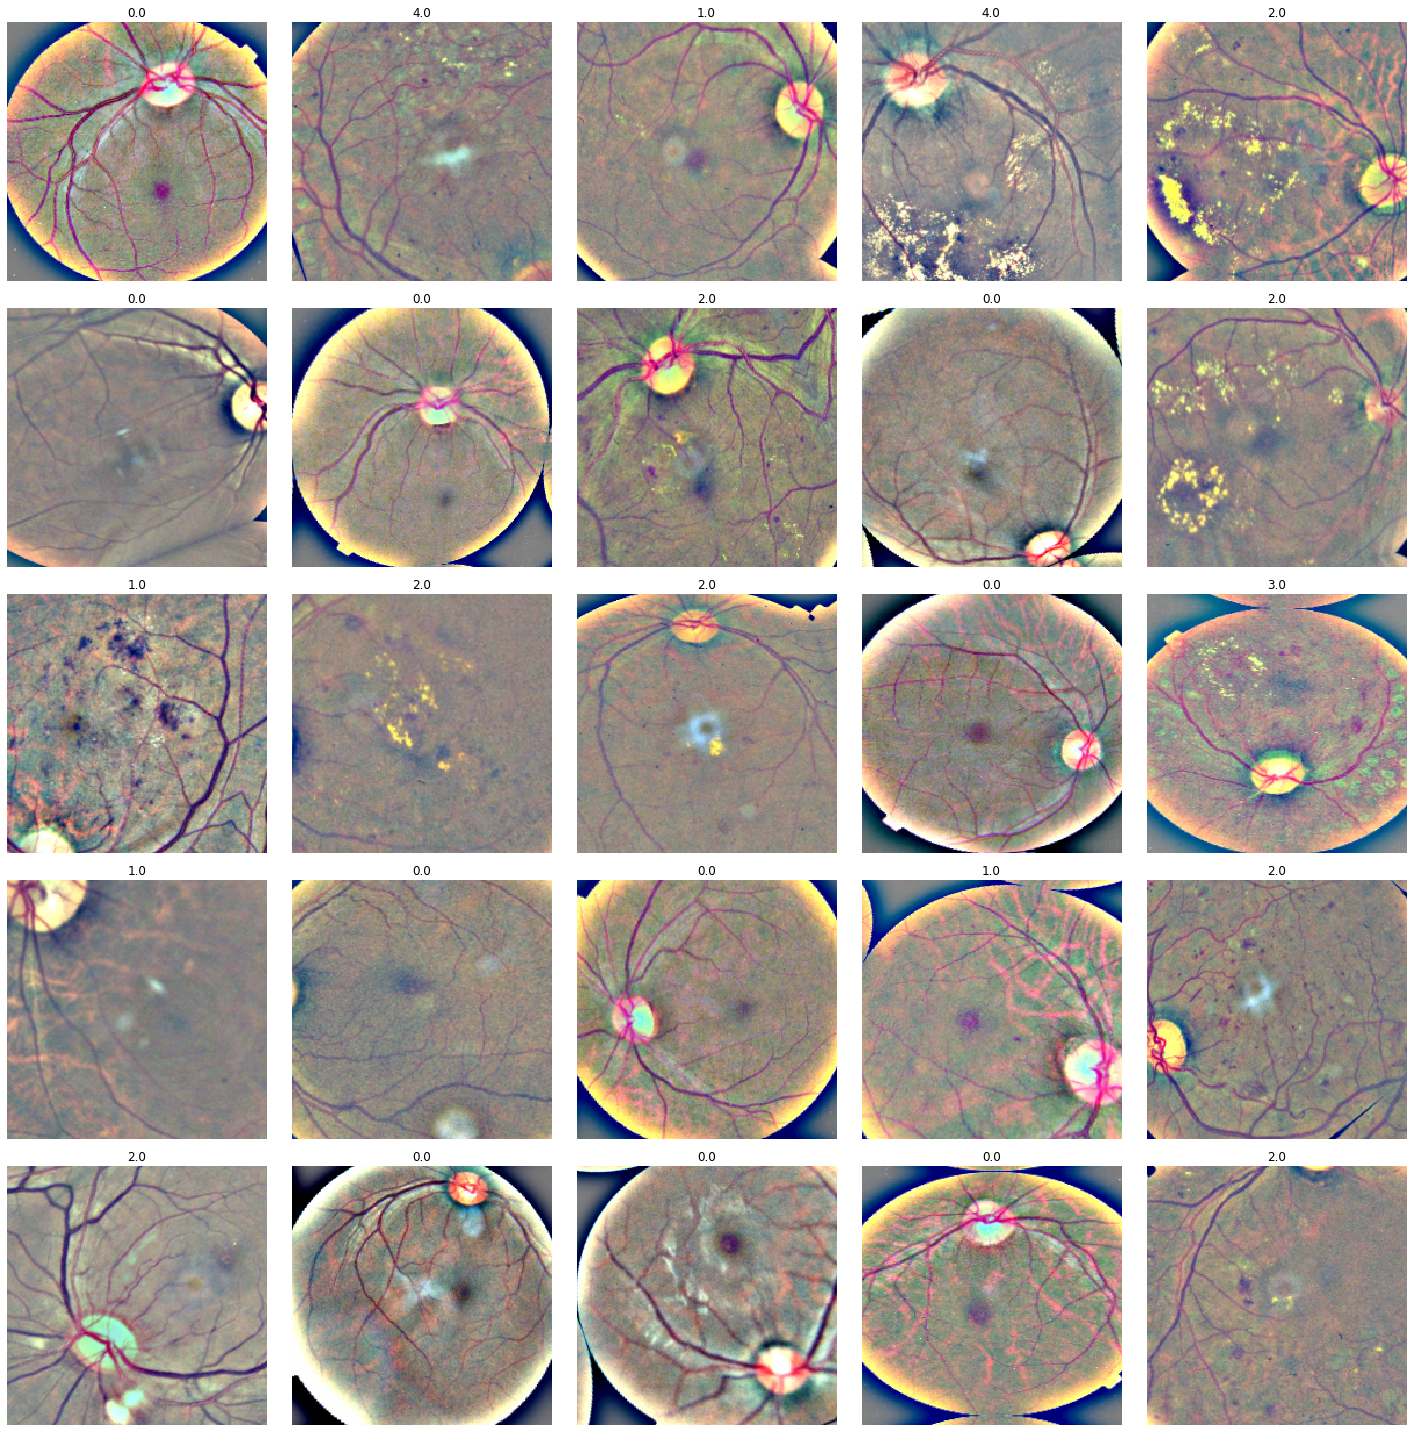

In [5]:
data.show_batch()

In [6]:
learn = Learner(data, md_ef, metrics = [quadratic_kappa], model_dir="models")
learn.load('NB_EXP_730_UNFREEZE_P1')
learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


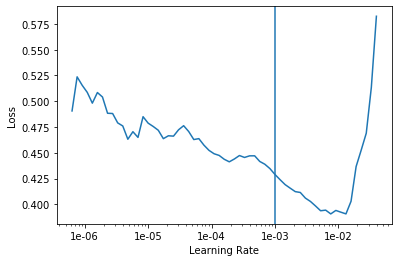

In [7]:
lr = 1e-3
learn.recorder.plot()
plt.axvline(lr)

In [8]:
SUFFIX = 'UNFREEZE_P1'
learn.fit_one_cycle(15,
                    lr, 
                    wd=1e-2,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}')])

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.395784,0.271600,0.900969,00:29
1,0.354665,0.253806,0.906205,00:30
2,0.323064,0.233087,0.911910,00:29
3,0.299689,0.229409,0.904481,00:29
4,0.286209,0.257792,0.895330,00:29
5,0.264334,0.261472,0.896623,00:29
6,0.249410,0.258545,0.905583,00:29
7,0.234192,0.245286,0.917329,00:30
8,0.219601,0.250238,0.914619,00:29
9,0.211579,0.245774,0.917155,00:29


Better model found at epoch 0 with valid_loss value: 0.2715998888015747.
Better model found at epoch 1 with valid_loss value: 0.2538056969642639.
Better model found at epoch 2 with valid_loss value: 0.23308731615543365.
Better model found at epoch 3 with valid_loss value: 0.2294093817472458.
